# Artwork sequence prediction

## Load data

In [2]:
import numpy as np
import pandas as pd
import tensorflow as tf

df_impressionist_sorted = pd.read_csv('impressionsist_sorted.csv')
impressionist_sorted_matrix = np.load('impressionist_sorted_matrix.npy')
df_impressionist_sorted.head()

,filename,title,style,genre,date,artist,imageUrl
0,44196.jpg,"La Hacienda Buenavista en Ponce, Puerto Rico",Impressionism,landscape,1840,francisco oller,https://uploads8.wikiart.org/images/francisco-...
1,50608.jpg,Woman and Child on a Bridge,Impressionism,genre painting,1848,honore daumier,https://uploads4.wikiart.org/images/honore-dau...
2,27526.jpg,On the Shore,Impressionism,genre painting,1853,honore daumier,https://uploads7.wikiart.org/images/honore-dau...
3,102063.jpg,Bathers,Impressionism,genre painting,1853,honore daumier,https://uploads4.wikiart.org/images/honore-dau...
4,66688.jpg,Study for the Self Portrait,Impressionism,self-portrait,1855,edgar degas,https://uploads6.wikiart.org/images/edgar-dega...


In [3]:
time = np.arange(impressionist_sorted_matrix.shape[0])

## Reset Tensorflow session

In [4]:
tf.keras.backend.clear_session()

## Split dataset

In [5]:
split_time = 4500
time_train = time[:split_time]
x_train = impressionist_sorted_matrix[:split_time]
time_valid = time[split_time:]
x_valid = impressionist_sorted_matrix[split_time:]

window_size = 20
batch_size = 256
shuffle_buffer_size = 1000

## Create models

In [10]:
from Prediction_model_feature import Prediction_model_feature

In [11]:
n_features = x_train.shape[1]
models = []

In [12]:
from IPython.display import clear_output
import time

start_time = time.time()
for i in range(n_features):
    clear_output(wait=True)
    print("---------- Feature %s -------------" % (i))
    model_prediction = Prediction_model_feature(
        x_train=x_train[:, i], batch_size=batch_size, window_size=window_size, 
        shuffle_buffer_size = shuffle_buffer_size )
    model_prediction.define_model()
    model_prediction.train_model(epochs=20, lr=1e-6)
    models.append(model_prediction)
    
print("--- %s seconds ---" % (time.time() - start_time))

---------- Feature 99 -------------
Epoch 1/20
18/18 [==============================] - 6s 309ms/step - loss: 1.6810 - mae: 2.1405
Epoch 2/20
18/18 [==============================] - 1s 64ms/step - loss: 0.5458 - mae: 0.9309
Epoch 3/20
18/18 [==============================] - 1s 64ms/step - loss: 0.4004 - mae: 0.7623
Epoch 4/20
18/18 [==============================] - 1s 64ms/step - loss: 0.3393 - mae: 0.6813
Epoch 5/20
18/18 [==============================] - 1s 64ms/step - loss: 0.3082 - mae: 0.6401
Epoch 6/20
18/18 [==============================] - 1s 64ms/step - loss: 0.2914 - mae: 0.6178
Epoch 7/20
18/18 [==============================] - 1s 63ms/step - loss: 0.2802 - mae: 0.6036
Epoch 8/20
18/18 [==============================] - 1s 64ms/step - loss: 0.2714 - mae: 0.5924
Epoch 9/20
18/18 [==============================] - 1s 64ms/step - loss: 0.2640 - mae: 0.5826
Epoch 10/20
18/18 [==============================] - 1s 64ms/step - loss: 0.2574 - mae: 0.5737
Epoch 11/20
18/18 [===

In [13]:
len(models)

100

In [ ]:
models[0].model.summary()

## Evaluate model

### Load decoder model

In [14]:
from tensorflow.python.keras.models import load_model

In [15]:
decoder_model = load_model('wasserstein_decoder.h5')
decoder_model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_transpose (Conv2DTran (None, 4, 4, 640)         1024640   
_________________________________________________________________
batch_normalization_6 (Batch (None, 4, 4, 640)         2560      
_________________________________________________________________
leaky_re_lu_6 (LeakyReLU)    (None, 4, 4, 640)         0         
_________________________________________________________________
conv2d_transpose_1 (Conv2DTr (None, 8, 8, 320)         3277120   
_________________________________________________________________
batch_normalization_7 (Batch (None, 8, 8, 320)         1280      
_________________________________________________________________
leaky_re_lu_7 (LeakyReLU)    (None, 8, 8, 320)         0         
_________________________________________________________________
conv2d_transpose_2 (Conv2DTr (None, 16, 16, 160)      

**Test decoder with example**

In [16]:
p = decoder_model.predict(x_train[1].reshape((1,1,1,-1)))

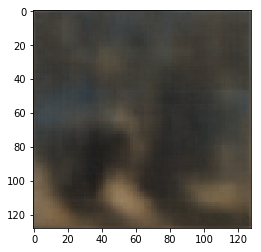

In [18]:
import matplotlib.pyplot as plt

plt.imshow(p[0][...,::-1])

### Predict features

**Sliced validation dataset**

In [19]:
def validation_dataset(series, window_size, batch_size):
    series = tf.expand_dims(series, axis=-1)
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size + 1, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size + 1))
    ds = ds.map(lambda w: (w[:-1], w[-1:]))
    return ds.batch(batch_size).prefetch(1)

**Predict features**

In [20]:
prediction = []

for i in range(n_features):
    val_dataset = validation_dataset(x_valid[:,i], window_size, batch_size)
    for x, y in val_dataset.take(1):
        prediction_feature = models[i].model.predict(x)[0]
        prediction.append(prediction_feature)

In [24]:
code = []
for p in prediction:
    code.append(prediction[0][0])

code = np.array(code)

In [26]:
code = code.reshape((-1,))

**Decode code**

In [30]:
p = decoder_model.predict(code.reshape((1,1,1,-1)))

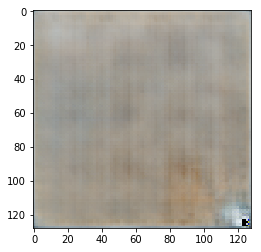

In [52]:
import matplotlib.pyplot as plt

plt.imshow(p[0])

In [41]:
valid_decode = decoder_model.predict(x_valid[0].reshape((1,1,1,-1)))

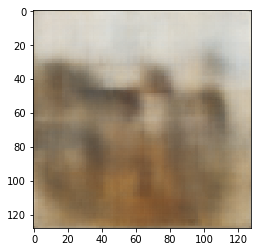

In [43]:
plt.imshow(valid_decode[0][...,::-1])

In [51]:
from sklearn.metrics.pairwise import cosine_similarity, cosine_distances

cosine_distances(code, x_valid[0][...,::-1])

array([[0.9142376]], dtype=float32)

### Plot feature prediction

In [32]:
from utils_plot import plot_series, plot_train_history, plot_prediction
import tensorflow as tf

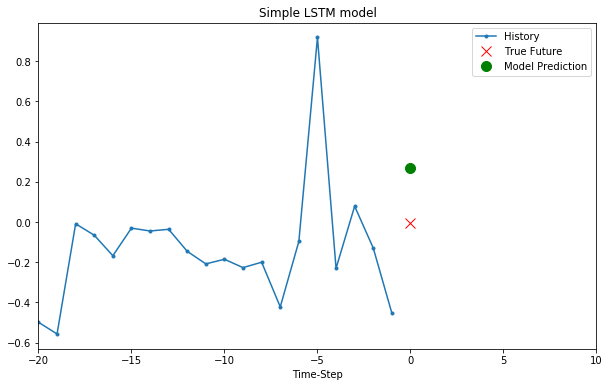

In [37]:
val_dataset = validation_dataset(x_valid[:,0], window_size, batch_size)
for x, y in val_dataset.take(1):
    prediction = models[0].model.predict(x)[0]
    plot = plot_prediction([x[0].numpy(), y[0].numpy(), prediction[0]] , 'Simple LSTM model')
    plot.show()

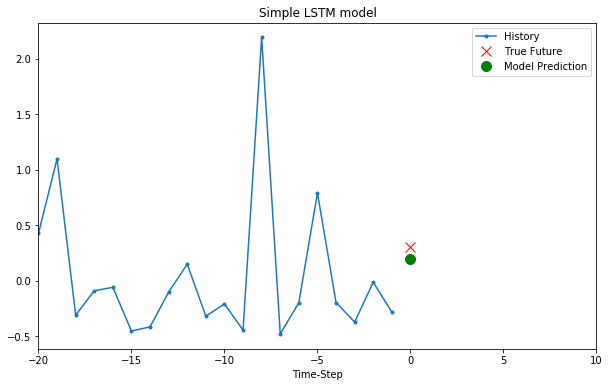

In [40]:
val_dataset = validation_dataset(x_valid[:,20], window_size, batch_size)
for x, y in val_dataset.take(1):
    prediction = models[20].model.predict(x)[0]
    plot = plot_prediction([x[0].numpy(), y[0].numpy(), prediction[0]] , 'Simple LSTM model')
    plot.show()

**Predict x_valid**

In [ ]:
def model_forecast(model, series, window_size, batch_size):
    series = tf.expand_dims(series, axis=-1)
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size))
    ds = ds.batch(batch_size).prefetch(1)
    forecast = model.predict(ds)
    return forecast

In [ ]:
x = np.concatenate((x_train[:, 1], x_valid[:, 1]))

In [ ]:
rnn_forecast = model_forecast(model_prediction.model, x, window_size, batch_size)

In [ ]:
rnn_forecast = rnn_forecast[split_time-window_size+1:,-1,0]

In [ ]:
plot_series(time_valid, [rnn_forecast], label="rnn")